- Plantear baseline / mvp
- Ventas -> + vendidos || + ingresos generan
- Rango de precios (premium, normal, etc...)
- Influencia de eventos en las ventas de los productos  
  
- Mantener las dimensiones por debajo de 4 a ser posible

# INIT

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [5]:
# !pip install featuretools # install the missing module # No lo vamos a usar esta vez

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

# Creacion caracteristicas
# import featuretools as ft

# Preprocesamiento
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler # Para evitar valores negativos

# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
# from modules import feature_creation_module as fcm
from modules import time_series_analisis as tma

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [7]:
CLUSTER_COL = 'cluster'
FIGSIZE = (12, 8)
FIG_SQUARE = (10,10)

## Importacion datos

### CSVs

In [8]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [9]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [10]:
# Seleccionar solo años 2014 a 2016 de df_s
df_s = df_s[(df_s['year'] >= 2014) & (df_s['year'] <= 2016)]

# df_s_origin = df_s.copy() # Para recuperar eventos

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

In [11]:
df_s.shape

(9693001, 12)

In [12]:
df_s.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8857275,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear
8857276,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear
8857277,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear
8857278,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear
8857279,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear


## Functions

In [13]:
# # Creacion caracteristicas
# def features_creation(df_items, df_shops, df_sales, fc_config, target, max_depth=1):
#   # Crear un EntitySet
#   es = ft.EntitySet(id='sales_data')

#   # Agregar entidades
#   es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
#   es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
#   es = es.add_dataframe(dataframe_name="sales", dataframe=df_sales,
#                         index="id", make_index=True, time_index="date")

#   # Definir relaciones
#   es = es.add_relationship("items", "item", "sales", "item")
#   es = es.add_relationship("shops", "store_code", "sales", "store_code")

#   # Generar características automáticas, ahora centradas en target
#   feature_matrix, feature_defs = ft.dfs(entityset=es,
#                                         target_dataframe_name=target,  # Objetivo: target
#                                         agg_primitives=fc_config['agg_primitives'],
#                                         trans_primitives=fc_config['trans_primitives'],  # Simple
#                                         max_depth=max_depth)

#   print("--------------------------------------------------------------------------------------------")
#   print(f"Feature Matrix shape {feature_matrix.shape}")

#   return feature_matrix, feature_defs

In [14]:
# # Obtener descripciones de las características
# def get_features_descriptions(features):
#     descriptions = []  # Inicializar lista vacía
#     for desc in features:
#         feat_desc = ft.describe_feature(desc)
#         descriptions.append(f'{desc}: {feat_desc}')  # Agregar a la lista
#         # print(f'{desc}: {feat_desc}')
#     return descriptions

In [15]:
# # Filtrar feature_matrix usando libreria featureTools
# def filter_feature_matrix(feature_matrix):
#     print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
#     print(f'Shape before filtering: {feature_matrix.shape[1]}')
#     filtered_features_matrix = feature_matrix.copy()
#     # filtered_features_matrix = ft.selection.remove_low_information_features(feature_matrix)
#     filtered_features_matrix = ft.selection.remove_highly_correlated_features(filtered_features_matrix)
#     filtered_features_matrix = ft.selection.remove_highly_null_features(filtered_features_matrix)
#     filtered_features_matrix = ft.selection.remove_single_value_features(filtered_features_matrix)
#     print(f'Shape after filtering: {filtered_features_matrix.shape[1]}')
#     print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
#     return filtered_features_matrix

In [16]:
# def preprocess_features(data, Scaler):
#   '''
#   Quieres que tus valores estén en un rango definido y positivo, lo cual es muy común en
#   análisis de precios o datos que requieren restricciones de signo (como precios o cantidades)
#   '''
#   # df = feature_matrix_renamed.copy()
#   scaler = Scaler()

#   scaled_data = scaler.fit_transform(data)
#   return pd.DataFrame(scaled_data, columns=data.columns)

In [17]:
# # KMEANS init
# def init_kmeans(k):
#   return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [18]:
# # KMEANS - Elbow & Silhouette
# def plot_elbow(data_scaled, ran=20):
#   distortions = []

#   for k in range(1, ran):
#       # kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
#       kmeans = init_kmeans(k)
#       kmeans.fit(data_scaled)
#       distortions.append(kmeans.inertia_)

#   fig = px.line(
#       x=range(1, 20),
#       y=distortions,
#       title="Elbow method - Inertia",
#       labels={"x": "k", "y": "Inertia"},
#   )
#   fig.show()

# # def plot_silhouette(data_scaled, ran=20):
# #   from sklearn.metrics import silhouette_score

# #   silhouette_scores = []

# #   for k in range(2, ran):
# #       # kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
# #       kmeans = init_kmeans(k)
# #       kmeans.fit(data_scaled)
# #       silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# #   fig = px.line(
# #       x=range(2, 20),
# #       y=silhouette_scores,
# #       title="Silhouette score",
# #       labels={"x": "k", "y": "Silhouette score"},
# #   )
# #   fig.show()

In [19]:
# # KMEANS - Vemos items por cluster
# def plot_clusters_sizes(data_labeled):
#     cluster_counts = data_labeled[CLUSTER_COL].value_counts().sort_index()
#     fig, ax = plt.subplots(figsize=(10, 6))
#     bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(range(len(cluster_counts))))

#     for bar in bars:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
#                 ha='center', va='bottom')

#     ax.set_xlabel(CLUSTER_COL)
#     ax.set_ylabel('Número de items')
#     ax.set_title('Número de items por cluster')
#     ax.set_xticks(range(len(cluster_counts)))
#     ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_counts))], rotation=0)
#     plt.show()

# # Añadimos clusters a data
# def add_labels_to_df(data, model):
#   data_labeled = data.copy()
#   data_labeled[CLUSTER_COL] = model.labels_
#   return data_labeled

In [20]:
# # PCAs
# # Funciones para ver variance en los PCA
# def view_pca_variance(data):
#     """
#     Aplica PCA al DataFrame y grafica la varianza explicada acumulada y por componente.

#     Parameters:
#     data (DataFrame): DataFrame con las características (features) sin incluir la columna 'Cluster'.
#     """
#     fig_size = (FIGSIZE)  # Ajustar tamaño para dos gráficos uno encima del otro

#     if CLUSTER_COL in data.columns:
#         data = data.drop(columns=[CLUSTER_COL])

#     data = data.select_dtypes(include='number')  # Quedarse solo con columnas numéricas

#     # Aplicar PCA
#     pca = PCA(n_components=None)  # Mantener todos los componentes
#     pca_result = pca.fit_transform(data)

#     # Obtener la varianza explicada en porcentaje
#     variance_ratio = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

#     # Crear una figura con dos subplots uno encima del otro
#     fig, ax = plt.subplots(2, 1, figsize=fig_size)  # 2 filas, 1 columna

#     # Gráfico 1: Varianza explicada acumulada
#     ax[0].plot(np.cumsum(variance_ratio), color='orange')
#     ax[0].set_xlabel('Número de Componentes')
#     ax[0].set_ylabel('Varianza Explicada Acumulada (%)')
#     ax[0].set_title('Varianza Explicada Acumulada')

#     # Añadir línea horizontal roja en el 90%
#     ax[0].axhline(y=90, color='red', linestyle='--', linewidth=1.5)

#     # Añadir líneas verticales discontinuas en gris en cada componente
#     for i in range(1, len(variance_ratio) + 1):
#         ax[0].axvline(x=i, color='gray', linestyle='--', alpha=0.7)
#     ax[0].grid(True)

#     # Gráfico 2: Varianza explicada por componente
#     ax[1].bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.7, color='orange', align='center')
#     ax[1].set_ylabel('Porcentaje de Varianza Explicada')
#     ax[1].set_xlabel('Número de Componente Principal')
#     ax[1].set_title('Varianza Explicada por Componentes')

#     # Añadir líneas verticales discontinuas en gris en cada componente
#     for i in range(1, len(variance_ratio) + 1):
#         ax[1].axvline(x=i, color='gray', linestyle='--', alpha=0.7)
#     ax[1].grid(True)

#     # Ajustar los espacios entre los subplots para evitar que se solapen
#     plt.tight_layout()

#     # Mostrar los gráficos
#     plt.show()

#     # Mostrar la varianza explicada en porcentaje para cada componente
#     print("Varianza explicada por cada componente (%):", variance_ratio)

#     return variance_ratio

# def calculate_accumulated_variance(variance_ratio):
#     # Calcular la varianza explicada acumulada
#     accumulated_variance = np.cumsum(variance_ratio)

#     # Crear un DataFrame con una fila y tantas columnas como componentes
#     df = pd.DataFrame([accumulated_variance],
#                       columns=[f'Componente {i+1}' for i in range(len(variance_ratio))])

#     return df

In [21]:
# # Dimension redux
# def dim_redux(data, n_components):
#   # Dim redux
#   pca = PCA(n_components)
#   pca_result = pca.fit_transform(data)
#   return pca, pca_result

# # Ploteamos 2D Clusters
# def plot_clusters_2D(data_pca, labels, centers):
#   plt.figure(figsize=FIG_SQUARE)
#   uniq = np.unique(labels)

#   for i in uniq:
#     plt.scatter(data_pca[label2 == i , 0] , data_pca[label2 == i , 1] , label = i)
#   plt.xlabel([])
#   plt.xlabel('PC1')
#   plt.ylabel('PC2')
#   plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#   plt.legend()
#   plt.show()

In [22]:
# # Explicacion clusters
# def clusters_boxplots(data_labeled):
#   display(data_labeled.shape)
#   # Assuming data_labeled contains your data
#   num_features = len(data_labeled.columns[1:-1])  # Exclude 'item' and 'cluster'

#   # Calculate number of rows and cols dynamically
#   num_cols = 3  # You can adjust this to change the grid layout
#   num_rows = (num_features + num_cols - 1) // num_cols

#   fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))

#   # Flatten axes array to iterate through it
#   axes = axes.flatten()

#   # Plot boxplots for each feature
#   for i, feature in enumerate(data_labeled.columns[1:-1]):
#     sns.boxplot(x=CLUSTER_COL, y=feature, data=data_labeled, ax=axes[i])
#     axes[i].set_title(f'Distribution of {feature} across Clusters')

#   # Hide empty subplots if any (when num_features is not divisible by num_cols)
#   for i in range(num_features, num_rows * num_cols):
#     if i < len(axes):  # Check if the extra subplot exists
#       axes[i].axis('off')

#   plt.tight_layout()
#   plt.show()

In [23]:
# def explain_clusters(model, labeled_data, num_features=5):
#     """
#     Explains clusters based on original features and creates a DataFrame with descriptions and feature values.
#     """
#     cluster_descriptions = []

#     for cluster in range(model.n_clusters):
#         cluster_desc = {}

#         cluster_data = labeled_data[labeled_data[CLUSTER_COL] == cluster]
#         cluster_feature_means = cluster_data.drop(columns=[CLUSTER_COL, 'item']).mean()

#         # Add feature values to cluster_desc
#         cluster_desc.update(cluster_feature_means.to_dict())

#         cluster_descriptions.append(cluster_desc)

#     df_cluster_desc = pd.DataFrame(cluster_descriptions, index=[f'Cluster {i}' for i in range(model.n_clusters)])
#     return df_cluster_desc

In [24]:
# # Función para obtener una paleta de colores consistente basada en los valores únicos de cluster_name
# def get_cluster_palette(data, group_col):
#     unique_clusters = data[group_col].unique()
#     palette = sns.color_palette('hls', len(unique_clusters))  # Usa 'Set2' o cualquier otra paleta
#     return dict(zip(unique_clusters, palette))

# # Función para graficar la evolución de una métrica agrupada por group_col
# def plot_evolution(data, date_col, group_col, value_col, title, ylabel, linewidth=1, figsize=(12, 5), agg='sum'):
#     """
#     Plotea la evolución de una métrica agrupada por una columna de agrupación.
#     """
#     # Asegurarse de que la columna de fecha es de tipo datetime
#     data[date_col] = pd.to_datetime(data[date_col])

#     # Agrupar los datos por la fecha y el grupo, y sumar los valores de la columna a graficar
#     grouped_data = data.groupby([date_col, group_col]).agg({value_col: agg}).reset_index()

#     # Generar una paleta de colores consistente para los clusters
#     palette = get_cluster_palette(data, group_col)

#     plt.figure(figsize=figsize)
#     sns.lineplot(
#         x=date_col, y=value_col, hue=group_col, data=grouped_data, palette=palette, linewidth=linewidth
#     )

#     # Añadir líneas verticales discontinuas para los días de eventos
#     event_days = data[data['event'] != 'None']

#     # Añadir líneas verticales discontinuas en gris con grosor 0.5 para todos los eventos
#     plt.vlines(event_days[date_col].unique(), ymin=plt.ylim()[0], ymax=plt.ylim()[1], color='gray', linestyle='--', linewidth=0.5)
#     plt.title(title)
#     plt.xlabel('Fecha')
#     plt.ylabel(ylabel)
#     plt.legend(title=group_col)
#     plt.show()

# # Función para graficar el porcentaje de una métrica agrupada por año y cluster_name
# def plot_percentage_bars(data, year_col, group_col, value_col, title, ylabel, figsize=(12, 5)):
#     """
#     Plotea un gráfico de barras mostrando el porcentaje de una métrica agrupada por año y group_col
#     """
#     # Agrupar los datos por el año y el grupo, y sumar los valores
#     grouped_data = data.groupby([year_col, group_col]).agg({value_col: 'sum'}).reset_index()

#     # Calcular el total anual para cada año
#     yearly_totals = grouped_data.groupby(year_col)[value_col].transform('sum')

#     # Calcular el porcentaje para cada cluster dentro de cada año
#     grouped_data['percentage'] = (grouped_data[value_col] / yearly_totals) * 100

#     # Generar una paleta de colores consistente para los clusters
#     palette = get_cluster_palette(data, group_col)

#     # Crear el gráfico de barras
#     plt.figure(figsize=figsize)
#     sns.barplot(
#         x=year_col, y='percentage', hue=group_col, data=grouped_data, palette=palette
#     )

#     # Añadir los porcentajes en la parte superior de cada barra
#     for container in plt.gca().containers:
#         plt.gca().bar_label(container, fmt='%.1f%%', label_type='edge')

#     # Título y etiquetas
#     plt.title(title)
#     plt.ylabel(ylabel)
#     plt.xlabel('Año')
#     plt.legend(title=group_col, loc='upper right')
#     plt.show()

# ::::::::: PENDING TASKS

- Cambiar valores de clusters por descripcion
- Visualizacion volumen de ventas por cluster - DONE
- Refactorizar funciones un unico bloque - DONE
- Limpiar modulos de funciones y refactorizar codigo

# ::::::::::::::::::::::::::::::::::::::::

In [25]:
print('DONE')

DONE


# ROTACION

## Functions

In [26]:
# Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [27]:
# CONSTANTES
CLUSTER_COL = 'cluster'
SCALER = RobustScaler
# REGIONS =

In [28]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(
      n_clusters=k,
      random_state=42,
      # init="random",
      init='k-means++', # Para que converja mas rapido
      n_init="auto",
      )

In [29]:
# 1. Preparación de datos
def prepare_data(data):
    # Convertir la columna 'date' a tipo datetime
    data['date'] = pd.to_datetime(data['date'])
    # Renombrar raw_sales a total_sales
    data.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return data

# 2. Crear características para análisis de rotación a nivel global, región y tienda
def create_features(data, level='global'):
    """
    Crea características agregadas para rotación de productos según el nivel ('global', 'region', 'store_code').
    Devuelve un DataFrame con una fila por producto a nivel global, por región, o por tienda.
    """
    prefix = f"{level}_" if level != 'global' else "global_"

    # Definir la lista de columnas a agrupar
    groupby_columns = ['item'] if level == 'global' else ['item', level]

    # Agrupación y agregación de datos
    feature_data = data.groupby(groupby_columns).agg(
        **{
            f'{prefix}avg_sell_price': ('sell_price', 'mean'),
            f'{prefix}total_units_sold': ('units', 'sum'),
            f'{prefix}avg_units_per_day': ('units', 'mean'),
            f'{prefix}std_sell_price': ('sell_price', 'std'),
            f'{prefix}std_units_sold': ('units', 'std')
        }
    ).reset_index()

    return feature_data

# 3. Segmentación de productos usando K-means con RobustScaler
def preprocess_features(X, Scaler=RobustScaler):
    """Rellenamos NaN y escalamos las características."""
    scaler = Scaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def init_kmeans(n_clusters):
    """Inicializa el algoritmo KMeans con el número de clusters especificado."""
    return KMeans(n_clusters=n_clusters, random_state=42)

# 3.1 Graficar Silhouette Score para varios valores de k
def plot_silhouette(data, level='global', ran=20):
    """
    Genera gráficos de Silhouette para diferentes valores de k a un nivel dado ('global', 'region', 'store').
    """
    if level == 'global':
        feature_columns = data.filter(like=f'{level}_').columns
        X = data[feature_columns].fillna(0)
        X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)

        silhouette_scores = []
        for k in range(2, ran):
            kmeans = init_kmeans(k)
            kmeans.fit(X_scaled)
            silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

        fig = px.line(
            x=range(2, ran),
            y=silhouette_scores,
            title="Silhouette score",
            labels={"x": "k", "y": "Silhouette score"},
        )
        fig.show()

    else:
        # Filtrar datos por el nivel especificado
        print(level)
        for group in data[level].unique():
            group_data = data[data[level] == group]
            feature_columns = group_data.filter(like=f'{level}_').columns
            X = group_data[feature_columns].fillna(0)
            X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)

            silhouette_scores = []
            for k in range(2, ran):
                kmeans = init_kmeans(k)
                kmeans.fit(X_scaled)
                silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

            fig = px.line(
                x=range(2, ran),
                y=silhouette_scores,
                title=f"Silhouette score para {level}: {group}",
                labels={"x": "k", "y": "Silhouette score"},
            )
            fig.show()

# 3.2 Segmentación por nivel
def segment_products_kmeans(data, n_clusters=3, level='global'):
    """
    Level puede ser: 'global', 'region', o 'store'
    """
    centroid_dfs = []  # Lista para almacenar los centroides de cada nivel

    if level == 'global':
        feature_columns = data.filter(like=f'{level}_').columns
        X = data[feature_columns].fillna(0)

        X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)
        kmeans = init_kmeans(n_clusters)
        clusters = kmeans.fit_predict(X_scaled)

        # Añadir la columna de clusters al DataFrame original
        data[f'{level}_cluster'] = clusters
        silhouette_avg = silhouette_score(X_scaled, clusters)
        print(f"El score de silueta promedio a nivel {level} es: {silhouette_avg}")

        # Centroides
        centroids = scaler.inverse_transform(kmeans.cluster_centers_)
        centroid_df = pd.DataFrame(centroids, columns=feature_columns)
        centroid_df['cluster'] = range(n_clusters)
        centroid_dfs.append(centroid_df)

        # Visualización
        visualize_results(data, centroid_df, level)

    else:
        # Agrupar y procesar datos para cada nivel
        for group in data[level].unique():
            group_data = data[data[level] == group].copy()  # Usar copy para evitar SettingWithCopyWarning
            feature_columns = group_data.filter(like=f'{level}_').columns
            X = group_data[feature_columns].fillna(0)

            X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)

            kmeans = init_kmeans(n_clusters)
            clusters = kmeans.fit_predict(X_scaled)

            # Añadir la columna de clusters al grupo de datos
            group_data[f'{level}_cluster'] = clusters
            silhouette_avg = silhouette_score(X_scaled, clusters)
            print(f"El score de silueta promedio a nivel {level} para {group} es: {silhouette_avg}")

            # Centroides
            centroids = scaler.inverse_transform(kmeans.cluster_centers_)
            centroid_df = pd.DataFrame(centroids, columns=feature_columns)
            centroid_df['cluster'] = range(n_clusters)
            centroid_df[level] = group  # Agregar la columna del nivel
            centroid_dfs.append(centroid_df)

            # Visualización
            visualize_results(group_data, centroid_df, level)

            # Actualizar el DataFrame original con los clusters asignados
            data.loc[data[level] == group, f'{level}_cluster'] = clusters

    # Concatenar centroides de todos los grupos
    if level != 'global':
        centroid_df = pd.concat(centroid_dfs, ignore_index=True)

    return data, centroid_df

# 4. Visualización de resultados
def visualize_results(product_segments, centroid_df, level='global'):
    if level == 'global':
        create_scatter_plot(product_segments, centroid_df, level)
    else:
        for group in product_segments[level].unique():
            print(f"\nSegmentación de productos por rotación a nivel {level} - {group}")
            group_data = product_segments[product_segments[level] == group]
            group_centroids = centroid_df[centroid_df[level] == group]
            create_scatter_plot(group_data, group_centroids, level, group)

def create_scatter_plot(data, centroids, level, group=None):
    plt.figure(figsize=(12, 6))

    # Scatterplot de clusters
    sns.scatterplot(data=data,
                    x=f'{level}_total_units_sold',
                    y=f'{level}_avg_sell_price',
                    hue=f'{level}_cluster',
                    palette='viridis')

    # Centroides
    sns.scatterplot(data=centroids,
                    x=f'{level}_total_units_sold',
                    y=f'{level}_avg_sell_price',
                    s=200,
                    color='red',
                    marker='X')

    title = f'Segmentación de productos por rotación a nivel {level}'
    if group:
        title += f' - {group}'

    plt.title(title)
    plt.xlabel('Total de unidades vendidas')
    plt.ylabel('Precio de venta promedio')
    plt.show()

# Uso de las funciones
# data = pd.read_csv('path/to/your/data.csv')
# data = prepare_data(data)
# features = create_features(data, level='region')  # O 'store' o 'global'
# plot_silhouette(features, level='region')  # O 'store' o 'global'
# segmented_data, centroids = segment_products_kmeans(features, n_clusters=3, level='region')  # O 'store' o 'global'


In [30]:
# Visualización del impacto en unidades vendidas por clúster
def analyze_rotation_impact(product_segments, level='global'):
    rotation_analysis = []

    # Definir el prefijo y la columna de clúster
    # prefix = f"{level}_" if level != 'global' else ""
    prefix = f'{level}_'
    cluster_col = f"{prefix}cluster"

    # Si no es global, analizar por cada valor de 'region' o 'store'
    if level != 'global':
        unique_levels = product_segments[level].unique()

        for target_value in unique_levels:
            # Filtrar datos por el valor actual del nivel (p.ej. una región o una tienda específica)
            filtered_data = product_segments[product_segments[level] == target_value]

            # Agrupar por clúster para obtener el promedio de ventas y unidades
            case_cluster_data = filtered_data.groupby(cluster_col).agg({
                f'{prefix}total_units_sold': 'mean',
                f'{prefix}avg_sell_price': 'mean',
            }).reset_index()

            # Calcular el impacto porcentual de unidades vendidas
            max_units = case_cluster_data[f'{prefix}total_units_sold'].max()
            case_cluster_data['units_impact'] = (case_cluster_data[f'{prefix}total_units_sold'] / max_units) * 100
            case_cluster_data[level] = target_value  # Añadir el valor del nivel (p.ej. región)
            rotation_analysis.append(case_cluster_data)

    else:
        print('eeeeee')
        print(prefix, cluster_col)
        # Si es global, agrupar por clúster a nivel global
        global_cluster_data = product_segments.groupby(cluster_col).agg({
            f'{prefix}total_units_sold': 'mean',
            f'{prefix}avg_sell_price': 'mean',
        }).reset_index()

        # Calcular el impacto porcentual de unidades vendidas a nivel global
        max_units = global_cluster_data[f'{prefix}total_units_sold'].max()
        global_cluster_data['units_impact'] = (global_cluster_data[f'{prefix}total_units_sold'] / max_units) * 100
        rotation_analysis.append(global_cluster_data)

    # Concatenar los resultados de cada nivel si no es global
    rotation_df = pd.concat(rotation_analysis, ignore_index=True)

    # Visualización del impacto en rotación por nivel y clúster
    plt.figure(figsize=(15, 10))

    # Si es por nivel, mostrar gráfico por cada valor del nivel (p.ej. región o tienda)
    if level != 'global':
        barplot = sns.barplot(x=level, y='units_impact', hue=cluster_col, data=rotation_df)
        plt.title(f'Impacto porcentual de unidades vendidas por {level} y clúster')
        plt.xlabel(level.capitalize())
        plt.ylabel('Cambio porcentual en unidades vendidas')

        # Añadir porcentajes encima de las barras
        for p in barplot.patches:
            barplot.annotate(f'{p.get_height():.1f}%',
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom',
                             fontsize=10, color='black',
                             xytext=(0, 5),
                             textcoords='offset points')

    else:
        # Si es global, mostrar un gráfico de clústeres
        barplot = sns.barplot(x=cluster_col, y='units_impact', data=rotation_df)
        plt.title('Impacto porcentual de unidades vendidas por clúster (Global)')
        plt.xlabel('Clúster')
        plt.ylabel('Cambio porcentual en unidades vendidas')

        # Añadir porcentajes encima de las barras
        for p in barplot.patches:
            barplot.annotate(f'{p.get_height():.1f}%',
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom',
                             fontsize=10, color='black',
                             xytext=(0, 5),
                             textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return rotation_df


In [31]:
print('DONE')

DONE


## Load data

In [32]:
items = df_items.copy()
shops = df_shops.copy()
df_rot = df_s.copy()

# Agregar la columna region a df_rot desde el df shops usando la columna 'store_code'
df_rot = df_rot.merge(shops[['store_code', 'region']], on='store_code', how='left')

df_rot.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event,region
0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear,New York
1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear,New York
2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear,New York
3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear,New York
4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear,New York


## Global

In [33]:
# Preparamos datos
data = prepare_data(df_rot)

target='global'

In [34]:
# Creamos caracteristicas por nivel
features = create_features(data, level=target)  # O 'store' o 'global'

In [35]:
# Silueta
plot_silhouette(features, level=target)  # O 'store' o 'global'

El score de silueta promedio a nivel global es: 0.8010654292290279


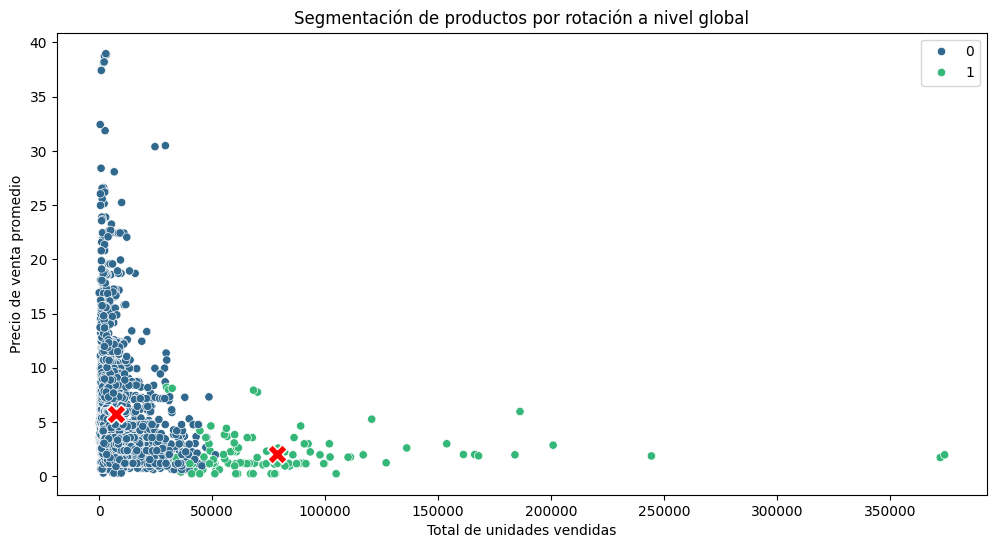

In [36]:
# Habria que tener en cuenta que los clusters pueden variar segun el nivel
segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)  # O 'store' o 'global'

In [37]:
segmented_data.head()

,item,global_avg_sell_price,global_total_units_sold,global_avg_units_per_day,global_std_sell_price,global_std_units_sold,global_cluster
0,ACCESORIES_1_001,10.991607,3504,1.393241,0.155606,0.720229,0
1,ACCESORIES_1_002,5.276346,2220,1.268571,0.094061,0.618826,0
2,ACCESORIES_1_003,3.943246,1435,1.220238,0.135582,0.548854,0
3,ACCESORIES_1_004,6.171200,17890,3.413471,0.000000,2.850305,0
4,ACCESORIES_1_005,3.815668,6569,1.704463,0.143314,1.010506,0


eeeeee
global_ global_cluster


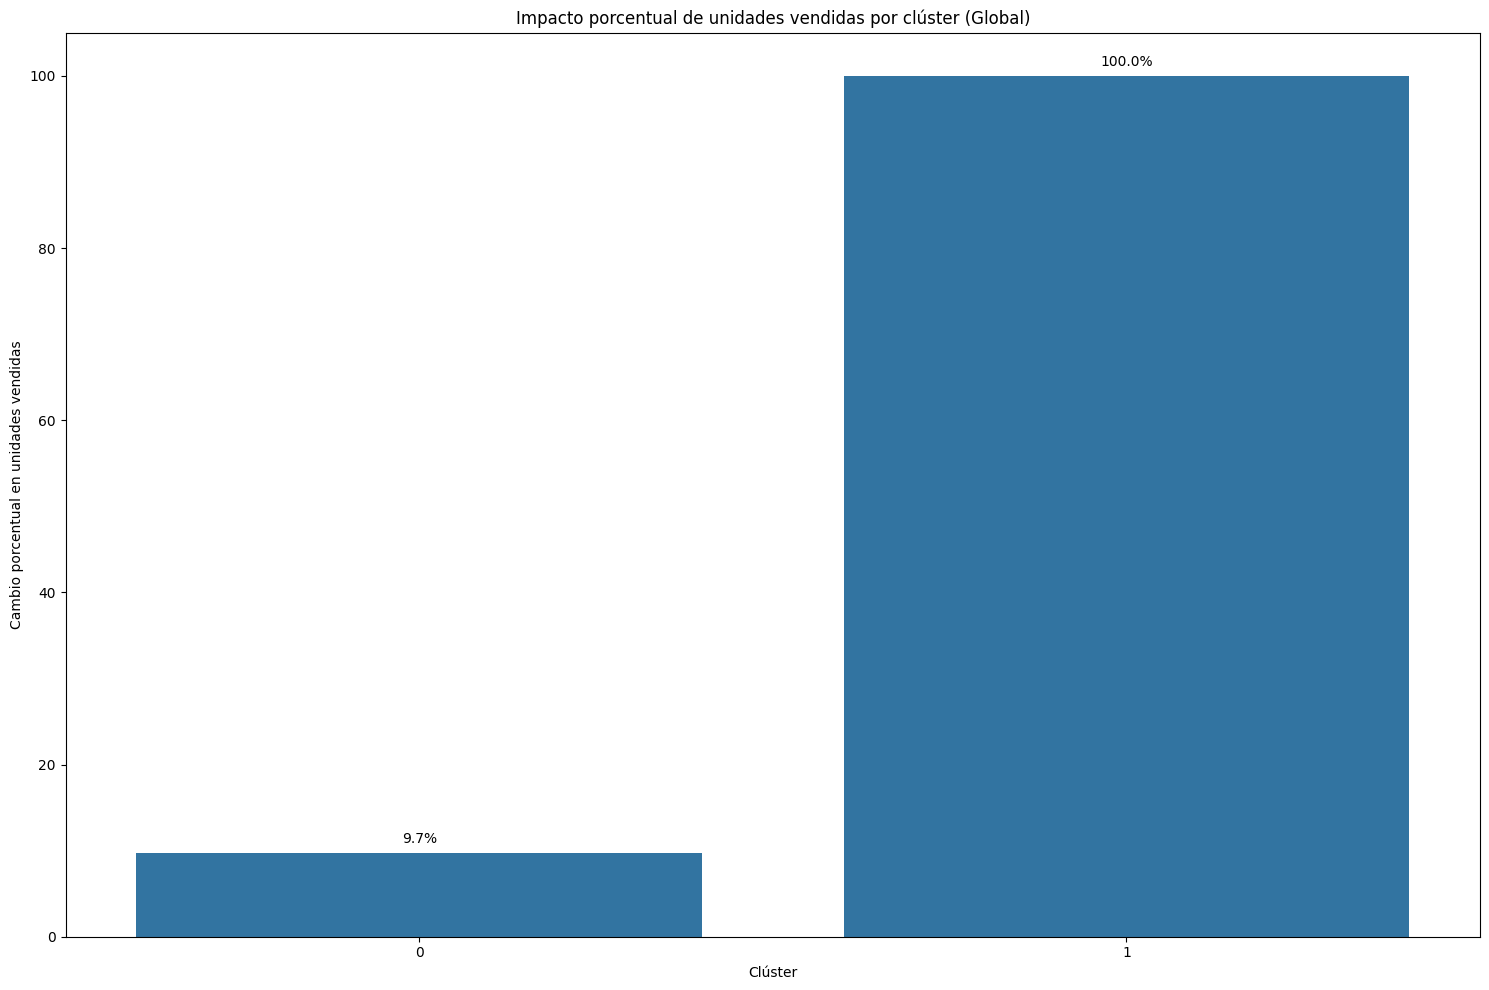

,global_cluster,global_total_units_sold,global_avg_sell_price,units_impact
0,0,7629.290686,5.729009,9.701265
1,1,78642.228814,2.028236,100.000000


In [38]:
# Impacto por region
rotation_impact_region = analyze_rotation_impact(segmented_data, level=target)
display(rotation_impact_region)

## Region

In [39]:
# Preparamos datos
data = prepare_data(df_rot)

target='region'

# Creamos caracteristicas por nivel
features = create_features(data, level=target)  # O 'store' o 'global'

In [40]:
# Silueta
plot_silhouette(features, level=target)  # O 'store' o 'global'

region


El score de silueta promedio a nivel region para Boston es: 0.8508752974997733

Segmentación de productos por rotación a nivel region - Boston


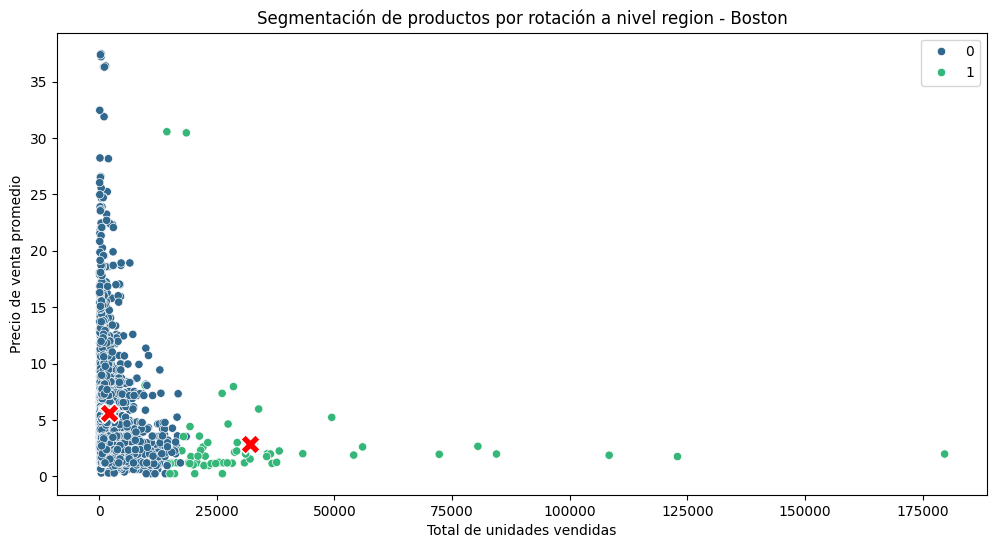

El score de silueta promedio a nivel region para New York es: 0.7672441574729238

Segmentación de productos por rotación a nivel region - New York


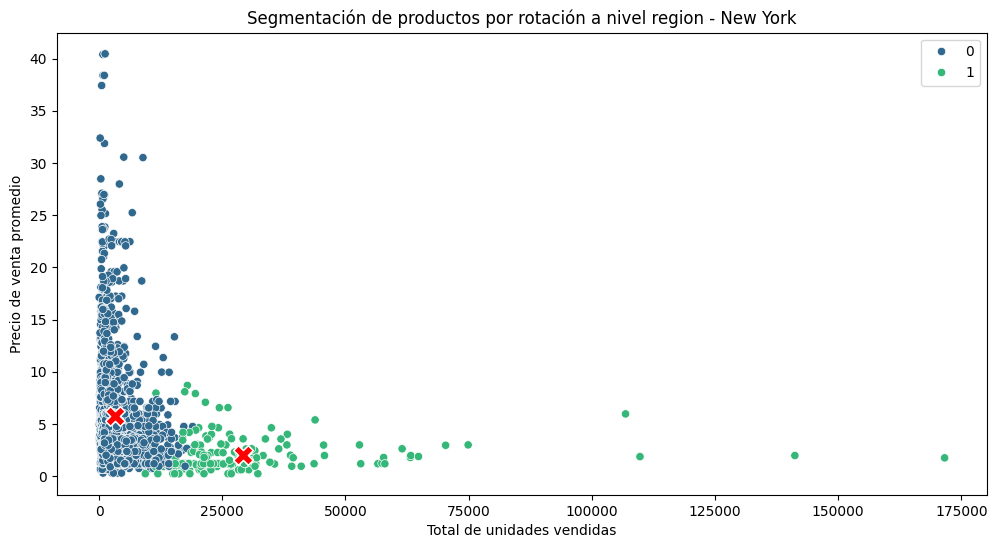

El score de silueta promedio a nivel region para Philadelphia es: 0.8036601029379161

Segmentación de productos por rotación a nivel region - Philadelphia


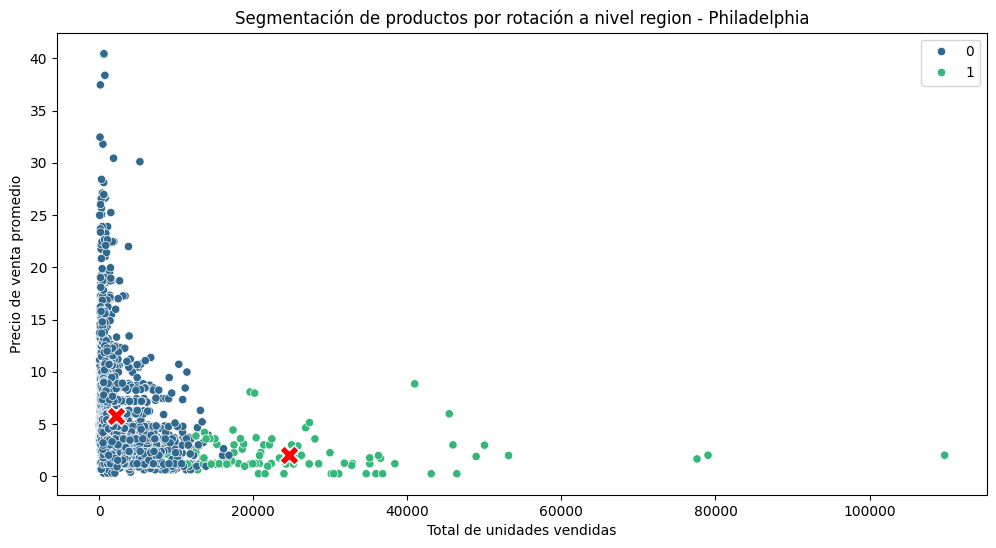

In [41]:
# Habria que tener en cuenta que los clusters pueden variar segun el nivel
# Aunque no sucede
segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)  # O 'store' o 'global'

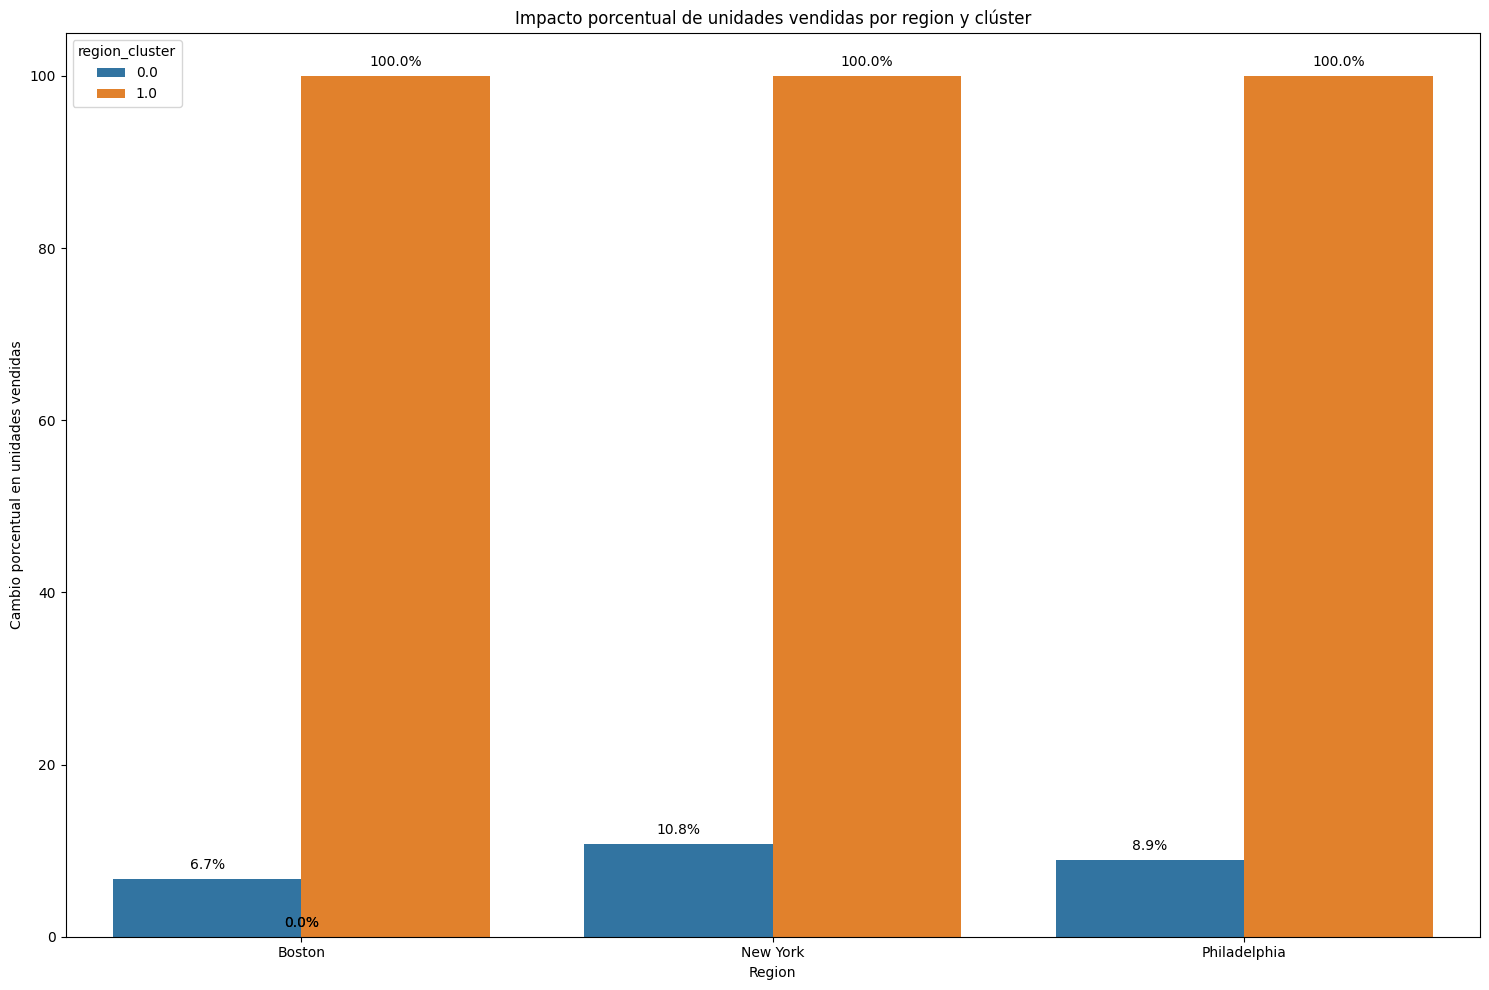

,region_cluster,region_total_units_sold,region_avg_sell_price,units_impact,region
0,0.0,2159.341176,5.622115,6.730271,Boston
1,1.0,32084.013514,2.833064,100.000000,Boston
2,0.0,3143.762284,5.791206,10.763564,New York
3,1.0,29207.446541,2.044559,100.000000,New York
4,0.0,2194.433333,5.736656,8.903417,Philadelphia
5,1.0,24647.092593,2.046950,100.000000,Philadelphia


In [42]:
# Impacto por region
rotation_impact_region = analyze_rotation_impact(segmented_data, level=target)
display(rotation_impact_region)

## Tiendas

In [43]:
# Preparamos datos
data = prepare_data(df_rot)

target='store_code'

In [44]:
# Creamos caracteristicas por nivel
features = create_features(data, level=target)  # O 'store' o 'global'

In [45]:
# Silueta
plot_silhouette(features, level=target)  # O 'store' o 'global'

store_code


El score de silueta promedio a nivel store_code para BOS_1 es: 0.8075753142509722

Segmentación de productos por rotación a nivel store_code - BOS_1


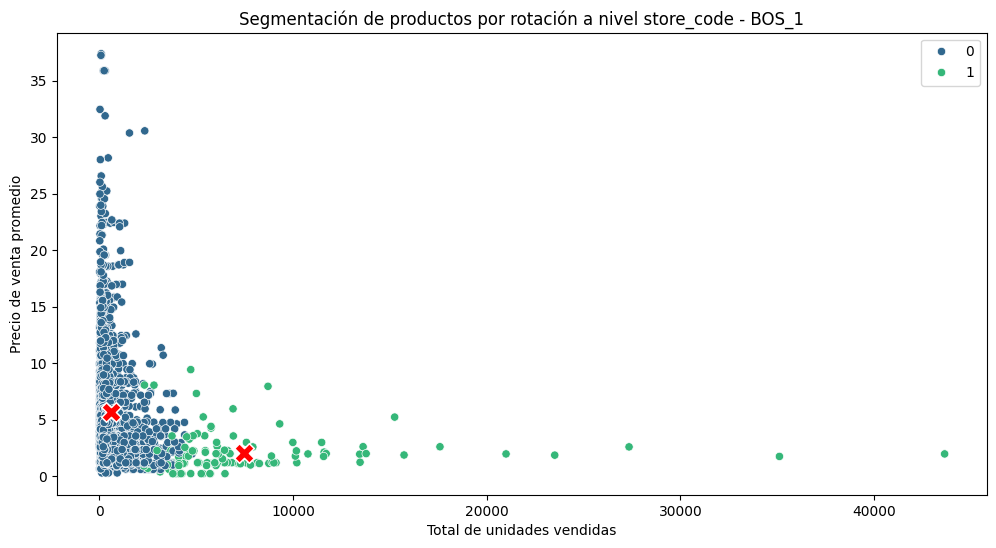

El score de silueta promedio a nivel store_code para BOS_2 es: 0.8985192477510732

Segmentación de productos por rotación a nivel store_code - BOS_2


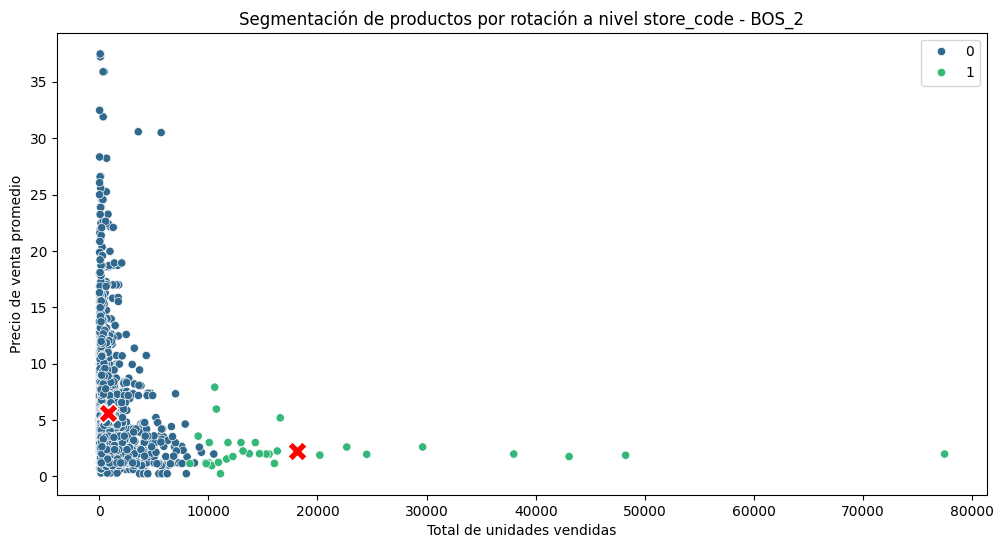

El score de silueta promedio a nivel store_code para BOS_3 es: 0.8832913890729974

Segmentación de productos por rotación a nivel store_code - BOS_3


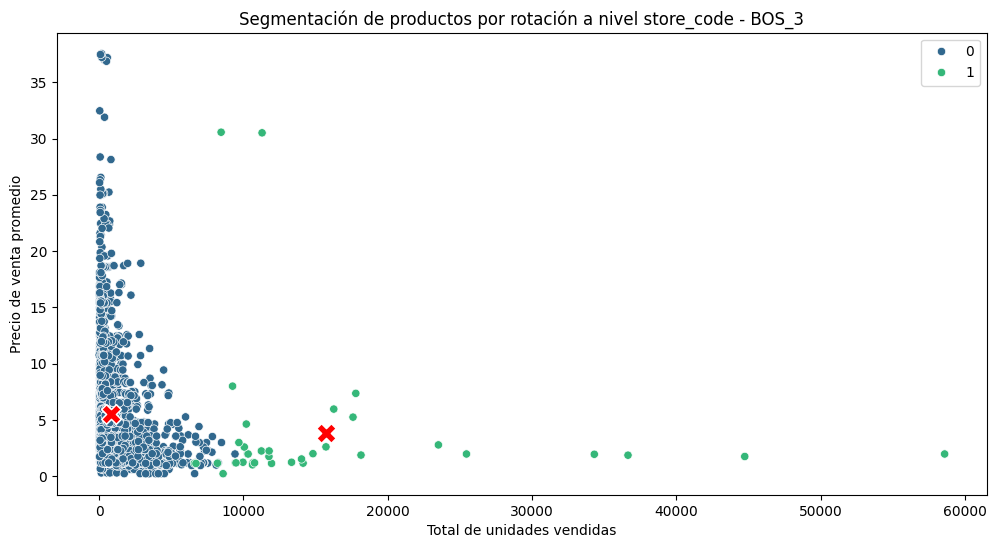

El score de silueta promedio a nivel store_code para NYC_1 es: 0.798082263280821

Segmentación de productos por rotación a nivel store_code - NYC_1


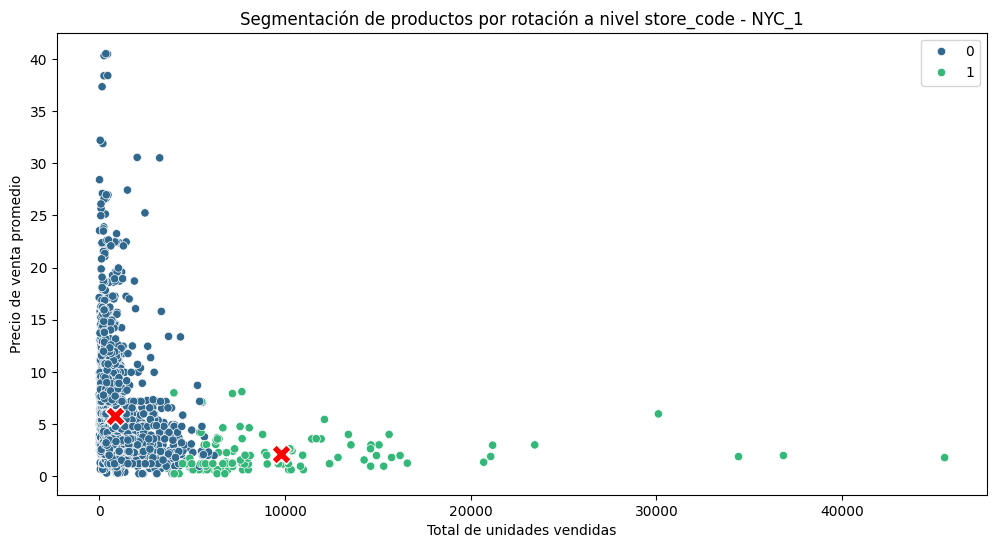

El score de silueta promedio a nivel store_code para NYC_2 es: 0.7088303446250711

Segmentación de productos por rotación a nivel store_code - NYC_2


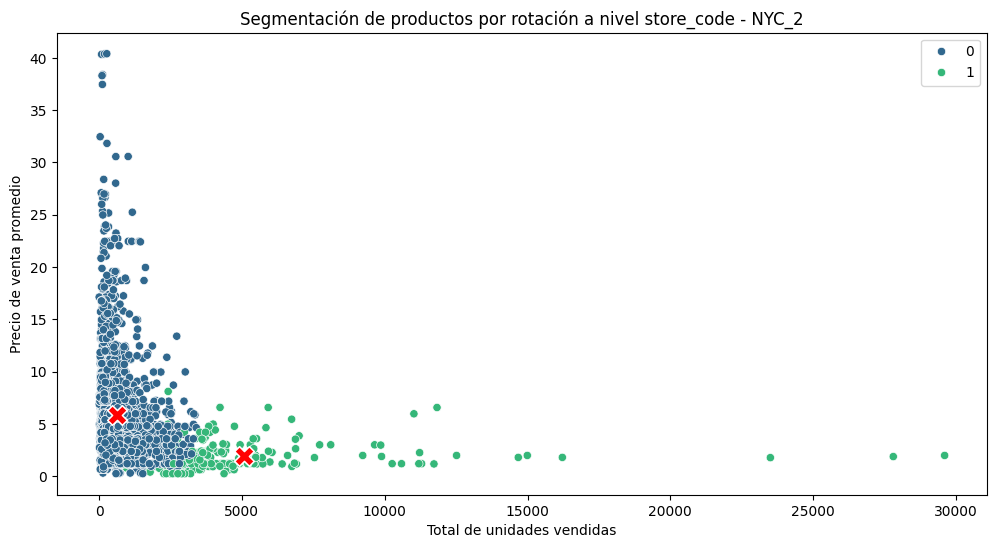

El score de silueta promedio a nivel store_code para NYC_3 es: 0.8080243608291648

Segmentación de productos por rotación a nivel store_code - NYC_3


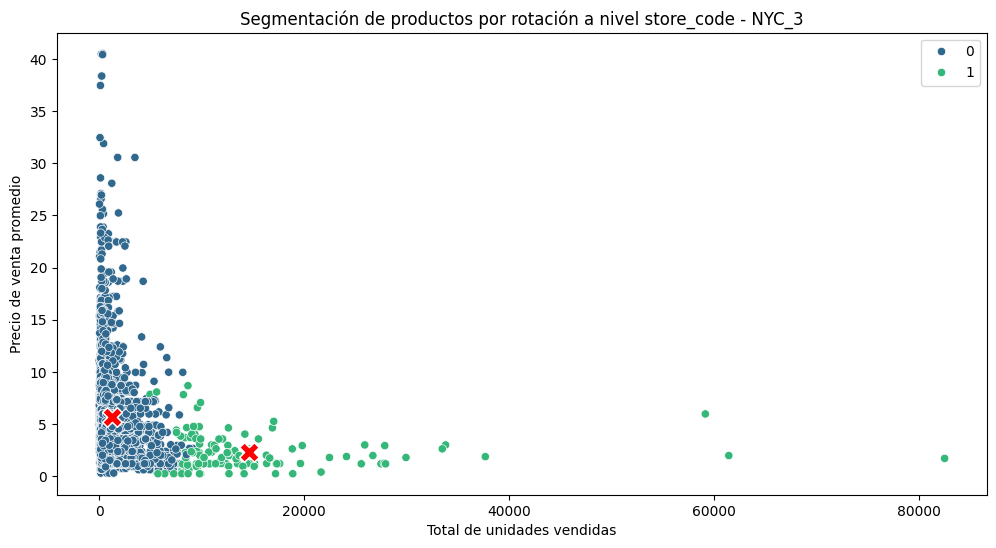

El score de silueta promedio a nivel store_code para NYC_4 es: 0.7314198501294342

Segmentación de productos por rotación a nivel store_code - NYC_4


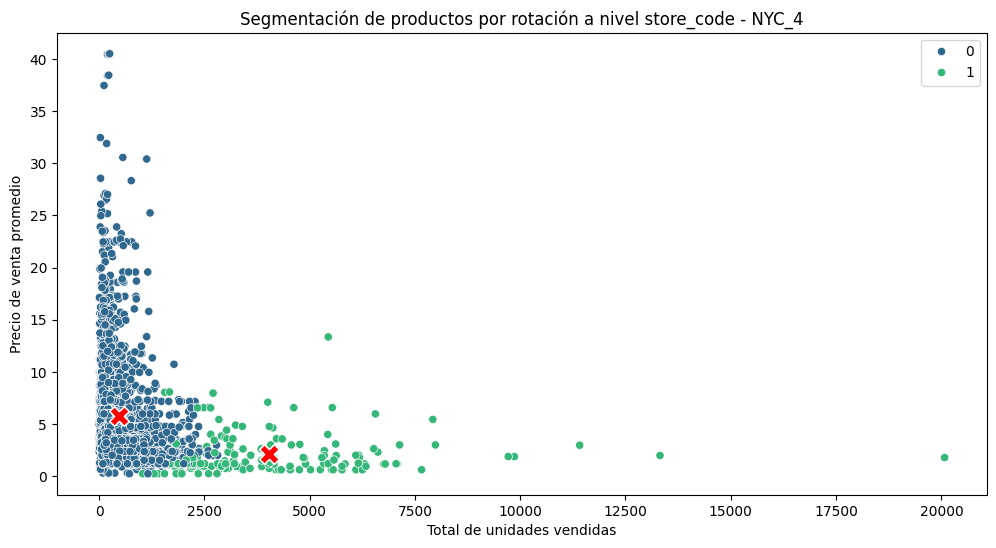

El score de silueta promedio a nivel store_code para PHI_1 es: 0.6911596706877632

Segmentación de productos por rotación a nivel store_code - PHI_1


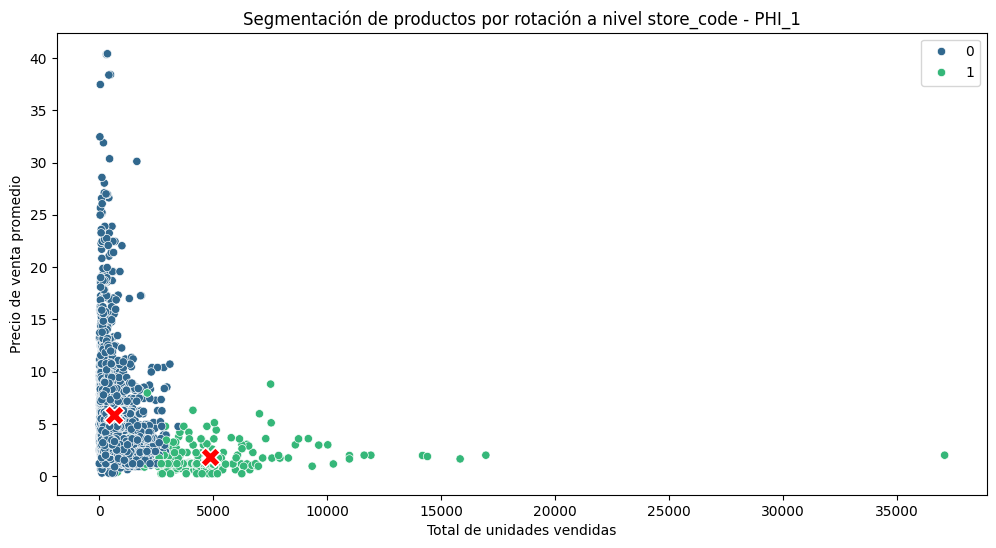

El score de silueta promedio a nivel store_code para PHI_2 es: 0.8412936965689254

Segmentación de productos por rotación a nivel store_code - PHI_2


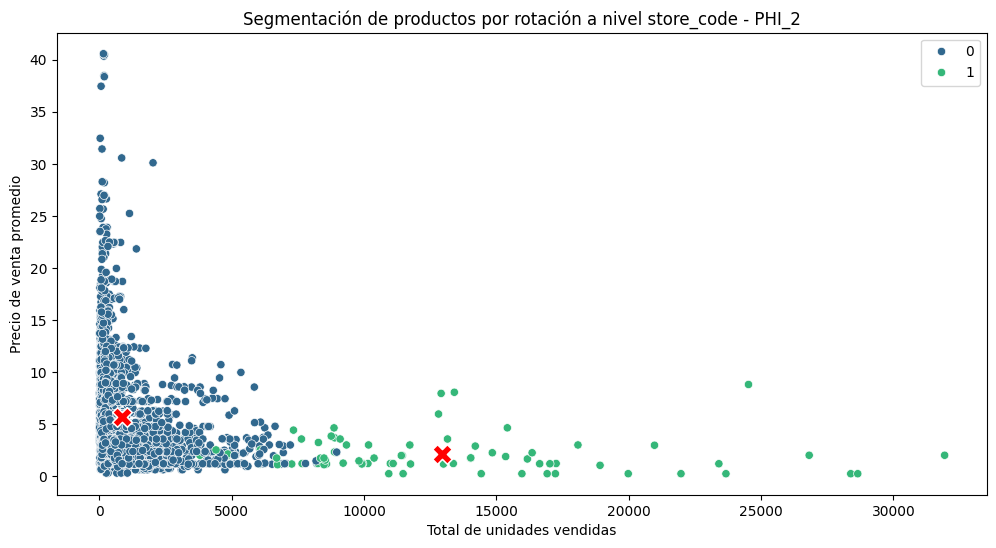

El score de silueta promedio a nivel store_code para PHI_3 es: 0.8546267386901701

Segmentación de productos por rotación a nivel store_code - PHI_3


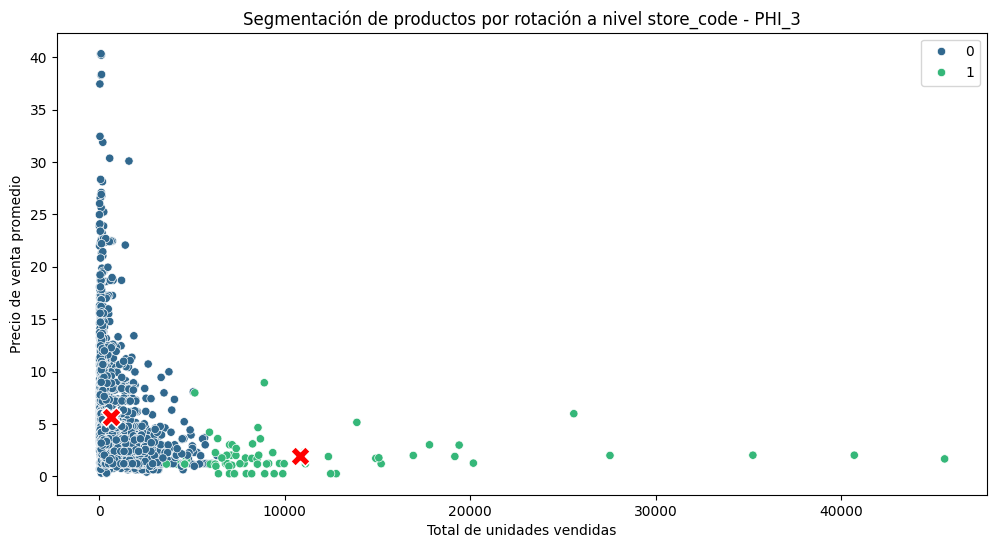

In [46]:
# Habria que tener en cuenta que los clusters pueden variar segun el nivel
segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)  # O 'store' o 'global'

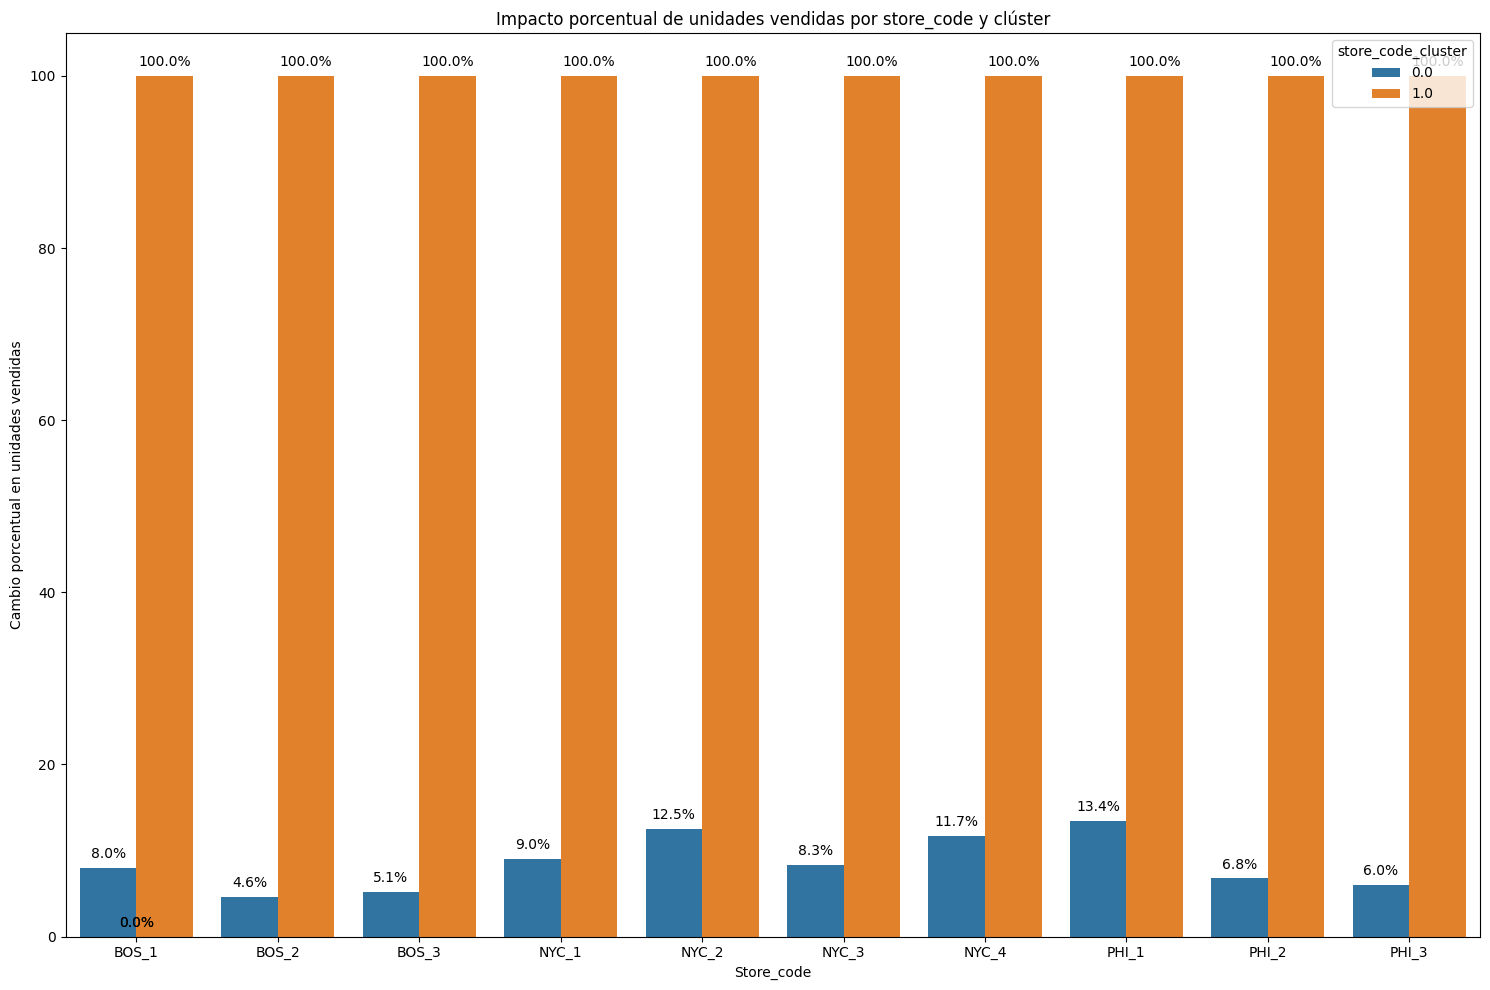

,store_code_cluster,store_code_total_units_sold,store_code_avg_sell_price,units_impact,store_code
0,0.0,595.812287,5.686907,7.986352,BOS_1
1,1.0,7460.381356,2.087397,100.000000,BOS_1
2,0.0,842.359867,5.587615,4.637975,BOS_2
3,1.0,18162.235294,2.284016,100.000000,BOS_2
4,0.0,808.160797,5.580059,5.134202,BOS_3
5,1.0,15740.729730,3.866330,100.000000,BOS_3
6,0.0,878.279387,5.734636,8.982126,NYC_1
7,1.0,9778.078947,2.085439,100.000000,NYC_1
8,0.0,632.391788,5.823063,12.464332,NYC_2
9,1.0,5073.611429,1.945539,100.000000,NYC_2


In [47]:
# Impacto por region
rotation_impact_region = analyze_rotation_impact(segmented_data, level=target)
display(rotation_impact_region)

# Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_rotation.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# df_items.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)